In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hlxon_hdf5io import *
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *

In [2]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return np.array([w, x, y, z])

In [3]:
def angular_distance(b, a):
    return np.where(np.abs(b-a) < 180, b-a, np.where((b-a) > 0, 360 - (b-a), 360 + (b-a)))

# Load data


In [4]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('RandomUDP3')

# p0 is first real pressure measurement
p0 = max(raw_pressure)

# convenience
X, Y, Z = 0, 1, 2
N = len(raw_timestamp)

# get sensor data
araw = np.array(raw_9dof[:, :3])
gyro = np.array(raw_9dof[:, 3:6])
magn = np.array(raw_9dof[:, 6:])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6


# Preprocess Data

In [5]:

rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
rots -= rots[0] # normalize to initial rot
rots = rots[:, ::-1] # reverse order of xyz to match ndof
rots[:, X] *= -1 # invert X rotations to match ndof
rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

# lerp rots
N = len(rots)

# interpolate over timestamps
lerped_rotations = np.zeros((N, 3))
for i in range(N):
    if gt_timestamp[i] in ts:
        lerped_rotations[i] = raw_rpy[np.argmax(ts == gt_timestamp[i])]
    else:
        # lerp
        ix_2 = np.argmax(ts > gt_timestamp[i])
        ix_1 = ts.shape[0] - np.argmax(np.flip(ts, axis=0) < gt_timestamp[i]) - 1

        lerped_rotations[i] = raw_rpy[ix_1] + (gt_timestamp[i]-ts[ix_1])*angular_distance(raw_rpy[ix_2], raw_rpy[ix_1])/(ts[ix_2] - ts[ix_1] + 1e-10)

rpy = lerped_rotations

# Interpolate signals into a unified sampling space
to properly evaluate the signals, both signals are interpolated into a unified sampling space using linear interpolation

In [6]:
# interpolate over time to create single sampling rate
fs = len(gt_timestamp) / gt_timestamp[-1]
CNT = int(fs*gt_timestamp[-1])
unified_ts = np.linspace(0, gt_timestamp[-1], CNT)

lerpedrpy = np.zeros((CNT, 3))
lerpedrots = np.zeros((CNT, 3))

for i in range(CNT):
    if unified_ts[i] in gt_timestamp:
        lerpedrpy[i] = rpy[np.argmax(gt_timestamp == unified_ts[i])]
        lerpedrots[i] = rots[np.argmax(gt_timestamp == unified_ts[i])]

    else:
        # lerp
        ix_2 = np.argmax(gt_timestamp > unified_ts[i])
        ix_1 = gt_timestamp.shape[0] - np.argmax(np.flip(gt_timestamp, axis=0) < unified_ts[i]) - 1

        lerpedrpy[i] = rpy[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rpy[ix_2], rpy[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
        lerpedrots[i] = rots[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rots[ix_2], rots[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)

rots = lerpedrots
rpy = lerpedrpy

# Extract Window with Largest Error

-31.408491614299948 168.45848414570034 160.1330242399997


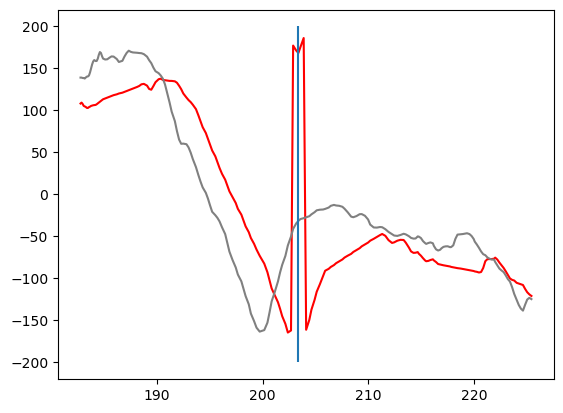

In [7]:
ixmax = np.argmax(np.linalg.norm(angular_distance(rpy, rots), axis=1))
print(rots[ixmax, X], rpy[ixmax, X], angular_distance(rpy[ixmax], rots[ixmax])[X])
windowsize = 200
window = (max(0, ixmax-windowsize//2), min(len(rpy)-1, ixmax+windowsize//2))

# plot positions as functions of time
fig = plt.figure()
ax = plt.axes()
ax.plot(gt_timestamp[window[0]:window[1]], rpy[window[0]:window[1], X], color='red')
ax.plot(gt_timestamp[window[0]:window[1]], rots[window[0]:window[1], X], color='gray')
ax.vlines(gt_timestamp[ixmax], -200, 200)
plt.show()


# Evaluate Performance

In [8]:
# Evaluate
print('-------------Shortest Angle Errors (norm of XYZ error)-------------')
# median angle error
ade = np.median(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle average angle error: {ade}')

# max angle error
mde = np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1).max()
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1)**2))
print(f'angle root mean squared angle error: {msde}')

print('-------------Individual Angle Component Errors-------------')
# median angle error
ade = np.median(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle average angle error: {ade}')

# max angle error
mde = (np.abs(angular_distance(rpy, rots))).max(axis=0)
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean((np.abs(angular_distance(rpy, rots)))**2, axis=0))
print(f'angle root mean squared angle error: {msde}')


-------------Shortest Angle Errors (norm of XYZ error)-------------
angle median angle error: 26.430283511288295
angle average angle error: 30.877615166996648
angle max angle error: 160.16659962553277
angle root mean squared angle error: 38.20137064285596
-------------Individual Angle Component Errors-------------
angle median angle error: [26.22888886  2.07342173  1.82685595]
angle average angle error: [30.37502544  2.41948142  2.20550881]
angle max angle error: [160.13302424  15.29433734  11.19939056]
angle root mean squared angle error: [37.97456525  3.05328634  2.8203822 ]


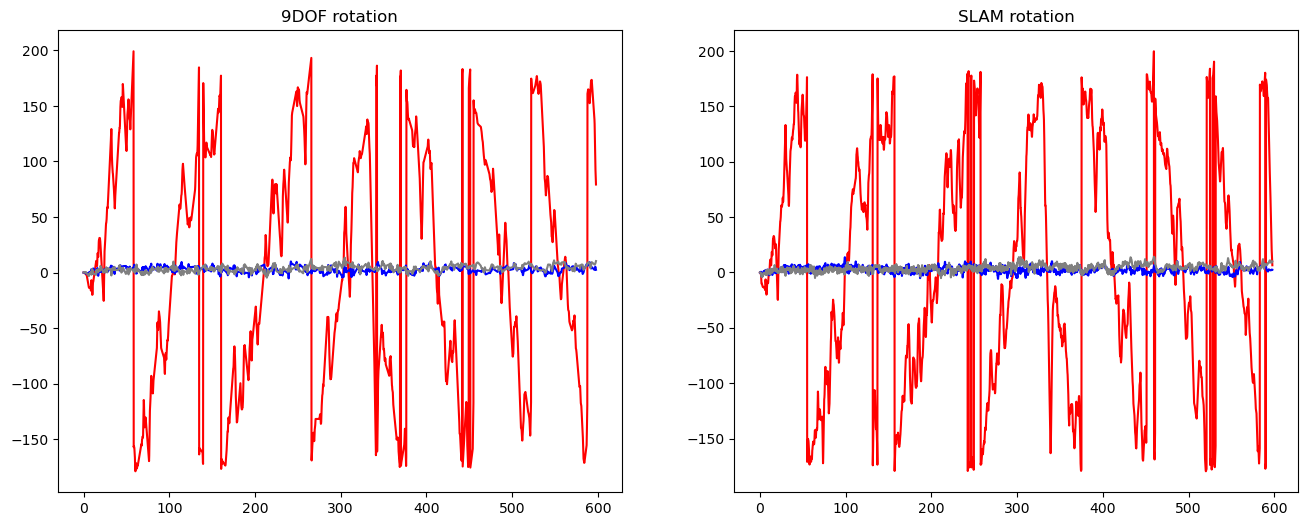

In [9]:

# plot positions as functions of time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.set_title('9DOF rotation')
ax1.plot(unified_ts, rpy[:, X], color='red')
ax1.plot(unified_ts, rpy[:, Y], color='blue')
ax1.plot(unified_ts, rpy[:, Z], color='gray')

ax2.set_title('SLAM rotation')
ax2.plot(unified_ts, rots[:, X], color='red')
ax2.plot(unified_ts, rots[:, Y], color='blue')
ax2.plot(unified_ts, rots[:, Z], color='gray')
plt.show()

# Evaluate over full dataset

In [10]:
# median angle error
mddes = []
# average angle error
ades = []
# max angle error
mxdes = []
# root mean squared error over angles
msdes = []

# median angle error
mddes_comp = []
# average angle error
ades_comp = []
# max angle error
mxdes_comp = []
# root mean squared error over angles
msdes_comp = []

In [11]:
dataset = readAll()

print('Processing', end='')
for sequence in dataset:
    print('.', end='')
    # get data from hdf5
    raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = sequence

    # p0 is first real pressure measurement
    p0 = max(raw_pressure)

    # convenience
    X, Y, Z = 0, 1, 2
    N = len(raw_timestamp)

    # get sensor data
    araw = np.array(raw_9dof[:, :3])
    gyro = np.array(raw_9dof[:, 3:6])
    magn = np.array(raw_9dof[:, 6:])
    pres = np.array(raw_pressure).reshape((-1, 1))
    alpha = 1.16e-4
    ts = np.array(raw_timestamp)*1e-6
    gt_timestamp = np.array(gt_timestamp)*1e-6


    rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
    rots -= rots[0] # normalize to initial rot
    rots = rots[:, ::-1] # reverse order of xyz to match ndof
    rots[:, X] *= -1 # invert X rotations to match ndof
    rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

    # lerp rots
    N = len(rots)

    # interpolate over timestamps
    lerped_rotations = np.zeros((N, 3))
    for i in range(N):
        if gt_timestamp[i] in ts:
            lerped_rotations[i] = raw_rpy[np.argmax(ts == gt_timestamp[i])]
        else:
            # lerp
            ix_2 = np.argmax(ts > gt_timestamp[i])
            ix_1 = ts.shape[0] - np.argmax(np.flip(ts, axis=0) < gt_timestamp[i]) - 1

            lerped_rotations[i] = raw_rpy[ix_1] + (gt_timestamp[i]-ts[ix_1])*angular_distance(raw_rpy[ix_2], raw_rpy[ix_1])/(ts[ix_2] - ts[ix_1] + 1e-10)

    rpy = lerped_rotations

    # interpolate over time to create single sampling rate for evaluation
    fs = len(gt_timestamp) / gt_timestamp[-1]
    CNT = int(fs*gt_timestamp[-1])
    unified_ts = np.linspace(0, gt_timestamp[-1], CNT)

    lerpedrpy = np.zeros((CNT, 3))
    lerpedrots = np.zeros((CNT, 3))

    for i in range(CNT):
        if unified_ts[i] in gt_timestamp:
            lerpedrpy[i] = rpy[np.argmax(gt_timestamp == unified_ts[i])]
            lerpedrots[i] = rots[np.argmax(gt_timestamp == unified_ts[i])]

        else:
            # lerp
            ix_2 = np.argmax(gt_timestamp > unified_ts[i])
            ix_1 = gt_timestamp.shape[0] - np.argmax(np.flip(gt_timestamp, axis=0) < unified_ts[i]) - 1

            lerpedrpy[i] = rpy[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rpy[ix_2], rpy[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
            lerpedrots[i] = rots[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rots[ix_2], rots[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)

    rots = lerpedrots
    rpy = lerpedrpy

    # median angle error
    mddes += [np.median(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))]
    # average angle error
    ades += [np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))]
    # max angle error
    mxdes += [np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1).max()]
    # root mean squared error over angles
    msdes += [np.sqrt(np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1)**2))]
    # median angle error
    mddes_comp += [np.median(np.abs(angular_distance(rpy, rots)), axis=0)]
    # average angle error
    ades_comp += [np.mean(np.abs(angular_distance(rpy, rots)), axis=0)]
    # max angle error
    mxdes_comp += [(np.abs(angular_distance(rpy, rots))).max(axis=0)]
    # root mean squared error over angles
    msdes_comp += [np.sqrt(np.mean((np.abs(angular_distance(rpy, rots)))**2, axis=0))]


Processing...........

In [12]:
mddes = np.mean(np.array(mddes))
ades = np.mean(np.array(ades))
mxdes = np.mean(np.array(mxdes))
msdes = np.mean(np.array(msdes))
print(f'mddes: {mddes}')
print(f'ades: {ades}')
print(f'mxdes: {mxdes}')
print(f'msdes: {msdes}')

mddes_comp = np.mean(np.array(mddes_comp), axis=0)
ades_comp = np.mean(np.array(ades_comp), axis=0)
mxdes_comp = np.mean(np.array(mxdes_comp), axis=0)
msdes_comp = np.mean(np.array(msdes_comp), axis=0)
print(f'mddes_comp: {mddes_comp}')
print(f'ades_comp: {ades_comp}')
print(f'mxdes_comp: {mxdes_comp}')
print(f'msdes_comp: {msdes_comp}')

mddes: 35.00844943072687
ades: 39.61357792787316
mxdes: 162.60451286931425
msdes: 48.12074426828499
mddes_comp: [34.39853668  3.75997108  2.4094784 ]
ades_comp: [38.61721097  4.09828924  2.84282446]
mxdes_comp: [162.46746704  21.50093779  18.21753029]
msdes_comp: [47.65039264  5.0096275   3.77308877]
